# Monte Carlo Default Simulation

We aim to estimate the expected loss up to time T:

$$E[L_T] = E\left[\sum_{i=1}^{N} \ell_i \cdot 1\{T_i \leq T\}\right]$$

Where:

- $\ell_i$ represents the loss amount from default $i$
- $T_i$ represents the default time for firm $i$
- $1\{T_i \leq T\}$ is the indicator function for defaults occurring before time $T$

## Model Components

### Firm Intensity Process
Each firm's default intensity is modeled as:

$$\lambda_t^i = X_i + \sum_{j=1}^{J} w_{ij} Y_t^j$$

Where:
- $X_i$ is the idiosyncratic component for firm $i$
- $Y_t^j$ is the sectoral intensity component
- $w_{ij}$ are loading factors representing sensitivity to sectoral factors

### Sectoral Intensity 

**We assume orthogonal sectors.**

$$dY_t^j = \kappa_j(\theta_j - Y_t^j)dt + \sigma_{j}\sqrt{Y_t^j}dW_t^j + \sum_{i=1}^{N}\delta_{ij}dL_t^i$$

Where:
- $\kappa_j$ is the mean reversion speed
- $\theta_j$ is the long-term mean level
- $\sigma_{j}$ are volatility parameters
- $W_t^j$ are standard Brownian motions
- $\delta_{ij}$ are contagion coefficients
- $L_t$ is the loss process 


## We experiment with integrating amortisation schedules in the above intensity based model.

### Hence the loss becomes LGD times the Exposure-at-Default.

We consider four repayment schedules. 
1) "Bullet" repayment where the outstanding principal is repaid in full at the time of "maturity".

2) "Linear/Italian" repayment scheme characterised by a constant repayment of principal in each installment.

3) "French" repayment scheme where a constant total installment (Principal + Interest) throughout the life of the loan is paid.

4) "Negative Amortisation" where the obligor continues to borrow and accrue further interest on the sum owed.

In [1]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

In [2]:
def lambda_max_generator(epsilon, y, theta, sigma, kappa, max_attempts=5, tol=1e-8):
    """
    
    Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.
    This function implements Equation (11) using the closed-form in Equation (19).

    """

    def G_y(H):

        a = H / kappa  # Now using H as the Laplace exponent (since tau ~ Exp(H))
        b = 2 * kappa * theta / sigma**2
        z_y = 2 * kappa * y / sigma**2
        z_H = 2 * kappa * H / sigma**2

        num = hyp1f1(a, b, z_y)
        denom = hyp1f1(a, b, z_H)
        
        return num / denom  # This is G_y(H; H) = E[e^{-H * sigma_H}]

    def root_function(H):
        return G_y(H) - epsilon

    # Bracketing interval
    H_min = y + 1e-8
    H_max = y + 10.0

    # Expand H_max until G_y(H_max) < epsilon
    for _ in range(max_attempts):
        try:
          H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
          
          if root_function(H_star)<=0:
            
            return H_star
          
          else:
          
            while root_function(H_star)>0:
              H_star = H_star + 1e-2
          
            return H_star
          
        except Exception:
            pass
        
        H_max += 5.0

    # Fallback: scan manually to find conservative H
    print("[Warning] brentq failed to converge. Using fallback grid search.")
    H_vals = np.linspace(H_min, H_max + 50, 1000)
    for H in H_vals:
        if G_y(H) <= epsilon:
            return H

    raise RuntimeError("Unable to find H^*_epsilon. Try expanding search space.")


In [3]:
def cir_transition_sample_per_sector(y_vec, tau, kappa_vec, theta_vec, sigma_vec, rng):
    """
    y_vec, kappa_vec, theta_vec, sigma_vec are arrays of length J (sectors).
    Returns xi_vec: sampled Y_{t+tau} per sector (length J).
    """
    if tau <= 0:
        return y_vec.copy()
    
    one_minus = -np.expm1(-kappa_vec * tau)  # = 1 - exp(-kappa*tau)
    # avoid zeros
    one_minus = np.where(one_minus <= 0, 1e-16, one_minus)
    
    c = (sigma_vec * sigma_vec * one_minus) / (4.0 * kappa_vec)
    d = 4.0 * kappa_vec * theta_vec / (sigma_vec * sigma_vec)
    
    # noncentrality parameters
    nc = (4.0 * kappa_vec * np.exp(-kappa_vec * tau) * y_vec) / (sigma_vec * sigma_vec * one_minus)
    
    # guard
    d = np.maximum(d, 1e-12)
    nc = np.maximum(nc, 0.0)
    
    # sample per sector (simple looping works fine since J would be typically small)
    xi = np.empty_like(y_vec, dtype=float)

    for j in range(len(y_vec)):
    
        # If df or nc are extreme, ncx2.rvs might throw an error
        try:
            Z = ncx2.rvs(df=d[j], nc=nc[j], random_state=rng)
    
        except Exception:
            Z = ncx2.rvs(df=max(d[j],1e-6), nc=0.0, random_state=rng) + nc[j]
    
        xi[j] = c[j] * Z
    
    xi = np.maximum(xi, 0.0)
    
    return xi


In [4]:
from scipy.interpolate import interp1d

def loss_distribution_plot(Payoff_T,index):
  # Get histogram data (without plotting)
  counts, bin_edges = np.histogram(Payoff_T, bins=10, density=True)

  # Get bin centers
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  # Interpolation function
  f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

  # New x-values for smooth curve
  x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
  y_smooth = f_interp(x_smooth)

  # Plot histogram and interpolated curve
  plt.hist(Payoff_T, bins=100, density=True, label='Histogram_'+str(index),alpha = 0.4)
  plt.plot(x_smooth, y_smooth, label='Loss Distribution Case_'+str(index))
  plt.xlabel('Loss')
  plt.ylabel('Density')
  # plt.legend()


In [5]:
def expected_shortfall(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    tail_losses = losses[losses >= var_alpha]
    return tail_losses.mean()

def compute_metrics(losses, alpha=0.95):
    return {
        "Mean": np.mean(losses),
        "Std": np.std(losses),
        "VaR": np.quantile(losses, alpha),
        "ES": expected_shortfall(losses, alpha),
        "Excess ES": expected_shortfall(losses, alpha) - np.quantile(losses, alpha),
        "ExcessKurtosis": kurtosis(losses)
    }


In [6]:
loan_types = ["bullet", "linear", "french", "negative"]

def bullet_exposure(contract, T, t):
    P = float(contract["P"])
    return P if t < T else 0.0


def linear_exposure(contract, T, t):
    P = float(contract["P"])
    N = int(contract["N"])
    if N <= 0 or T <= 0:
        return 0.0

    period = T / N
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, N))
    principal_paid = (payments_made / N) * P
    return max(P - principal_paid, 0.0)


def french_exposure(contract, T, t):
    P = float(contract["P"])
    N = int(contract["N"])
    r = float(contract["r"])
    if N <= 0 or T <= 0:
        return 0.0

    period = T / N
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, N))
    periods_remaining = N - payments_made
    if periods_remaining <= 0:
        return 0.0

    r = r / N  # Convert annual rate to per-period rate

    if r == 0.0:
        payment = P / N
        return payment * periods_remaining

    annuity_payment = P * r / (1.0 - (1.0 + r) ** (-N))
    pv_remaining = annuity_payment * (1.0 - (1.0 + r) ** (-periods_remaining)) / r
    return pv_remaining


def negative_amortization_exposure(contract, T, t):
    P = float(contract["P"])
    N = int(contract["N"])
    r = float(contract.get("r", 0.0))
    if N <= 0 or T <= 0:
        return max(P, 0.0)

    period = T / N
    periods_elapsed = int(np.floor(t / period))
    periods_elapsed = int(np.clip(periods_elapsed, 0, N))

    r = r / N  # Convert annual rate to per-period rate

    # Borrowing/interest accrues; no principal repayment until maturity
    exposure = P * ((1.0 + r)**(periods_elapsed))

    return exposure if t < T else 0.0


def exposure_at_time(contract, T, t):
    loan_type = str(contract["type"]).lower()
    dispatch = {
        "bullet": bullet_exposure,
        "linear": linear_exposure,
        "french": french_exposure,
        "negative_amortisation": negative_amortization_exposure,
    }
    if loan_type not in dispatch:
        raise ValueError(f"Unknown loan type: {loan_type}")
    return dispatch[loan_type](contract, T, t)



In [7]:
def simulate_sector_cir_model(kappa, theta, sigma, T, delta, W, eps, lambda_benchmark,
                              Nfirms, idiosyncratic_factor, loan_contracts, rng=None):

    import warnings

    if rng is None:
        rng = np.random.default_rng()

    # ensure shapes
    J = len(theta)
    assert W.shape == (Nfirms, J)
    idiosyncratic_factor = np.asarray(idiosyncratic_factor).reshape(Nfirms,)
    lambda_benchmark = np.asarray(lambda_benchmark).reshape(J,)

    delta = np.asarray(delta)
    if delta.ndim == 1:
        delta = np.tile(delta.reshape(1, J), (Nfirms, 1))
    assert delta.shape == (Nfirms, J)

    # init
    t = 0.0
    Y_t = theta.copy().astype(float)   # sectoral intensities (J-vector), initialised at theta
    events = []
    owed = []
    marks = []
    defaulter_idio_factor = []
    sector_contributions = []
    alive = np.arange(Nfirms, dtype=int)

    # precompute some arrays for speed
    kappa = np.asarray(kappa, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    theta = np.asarray(theta, dtype=float)

    # event loop
    while (t < T) and (alive.size > 0):

        lambda_max = np.maximum(Y_t, lambda_benchmark)  # J-vector
        # Hepsilon = sum_i [ X_i + w_i · lambda_max ] over alive firms
        
        # We can compute per-firm value and sum
        per_firm_sys = W[alive].dot(lambda_max)   # length alive.size
        per_firm_idio = idiosyncratic_factor[alive]
        Hepsilon = per_firm_sys.sum() + per_firm_idio.sum()

        if Hepsilon <= 0:
            break

        # sample a candidate waiting time
        tau = rng.exponential(1.0 / Hepsilon)
        t_candidate = t + tau
        if t_candidate >= T:
            break

        # sample sectoral Y at t_candidate conditional on no defaults in the waiting time
        Y_proposed = cir_transition_sample_per_sector(Y_t, tau, kappa, theta, sigma, rng)

        # compute proposed per-firm intensities (scalar values) using Y_proposed
        per_firm_sys_prop = W[alive].dot(Y_proposed)
        per_firm_total_prop = per_firm_sys_prop + per_firm_idio
        lambda_proposed_total = per_firm_total_prop.sum()

        # acceptance probability: Xi / Hepsilon where Xi = lambda_proposed_total
        accept_prob = min(lambda_proposed_total / Hepsilon, 1.0)
        if rng.random() < accept_prob:
            # accept a default at t_candidate
            t = t_candidate
            events.append(t)

            # choose which alive firm defaulted
            probs = per_firm_total_prop / lambda_proposed_total
            probs = np.maximum(probs, 0.0)
            probs = probs / probs.sum()
            selected_local_idx = rng.choice(len(alive), p=probs)
            selected_firm = int(alive[selected_local_idx])

            # record idiosyncratic factor
            defaulter_idio_factor.append(float(idiosyncratic_factor[selected_firm]))

            sector_contributions.append(W[selected_firm].copy())

            # mark (loss) from contract exposure
            contract = loan_contracts[selected_firm]
            exposure = exposure_at_time(contract, T, t)
            if exposure < 0:
                warnings.warn("Exposure computed negative; clamping to zero.")
                exposure = max(exposure, 0.0)
            if t >= T and exposure > 0:
                warnings.warn("Exposure positive after maturity; forcing to zero.")
                exposure = 0.0

            owed.append(exposure)
            
            # LGD = rng.uniform(0,1)
            # mark = LGD * exposure
            mark =  exposure
            if mark < 0:
                warnings.warn("Loss mark negative; clamping to zero.")
                mark = max(mark, 0.0)
            marks.append(mark)

            # update Y_t with contagion
            Y_t = Y_proposed + delta[selected_firm] * mark/contract["P"]

            # remove defaulted firm from alive set
            alive = np.delete(alive, selected_local_idx)

        else:
            # reject, ie no default: advance time and set Y_t = Y_proposed
            t = t_candidate
            Y_t = Y_proposed

    return (np.array(events), np.array(marks), np.array(owed),
            np.array(defaulter_idio_factor), np.array(sector_contributions))

In [8]:
def generate_portfolio_weights(N, J, composition_type, concentration_params=None, rng=None):
    """
    Build portfolio weights under three stylised configurations plus a random fallback.

    - concentrated: one dominant sector for every obligor (eg for J=3 [0.7, 0.2, 0.1])
    - balanced: evenly distributed across sectors (eg for J=3  [1/3, 1/3, 1/3])
    - mixed: partial concentration with residual diversified weights (eg for J=3  [0.5, 0.3, 0.2])
    - random: symmetric Dirichlet for variation.
    """
    if rng is None:
        rng = np.random.default_rng()

    if concentration_params is None:
        concentration_params = {}

    noise_level = concentration_params.get("noise_level", 0.0)
    alpha_random = concentration_params.get("alpha", 1.0)

    if composition_type == "concentrated":
        pattern = _pattern_concentrated(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "balanced":
        pattern = _pattern_balanced(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "mixed":
        pattern = _pattern_mixed(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "random":
        W = _generate_random_weights(N, J, {"alpha": alpha_random}, rng)
    else:
        raise ValueError(f"Unknown composition_type: {composition_type}")

    return W


def _pattern_concentrated(J, dominant=0.7):
    if J <= 0:
        return np.array([])
    if J == 1:
        return np.array([1.0])
    residual = max(1.0 - dominant, 0.0)
    tail = residual / (J - 1)
    vec = np.full(J, tail)
    vec[0] = dominant
    return vec


def _pattern_balanced(J):
    if J <= 0:
        return np.array([])
    return np.full(J, 1.0 / J)


def _pattern_mixed(J, primary=0.5, secondary=0.3):
    if J <= 0:
        return np.array([])
    vec = np.zeros(J)
    vec[0] = min(primary, 1.0)
    if J >= 2:
        vec[1] = min(secondary, max(1.0 - vec[0], 0.0))
    residual = max(1.0 - vec.sum(), 0.0)
    if J > 2:
        vec[2:] = residual / (J - 2)
    elif J == 1:
        vec[0] = 1.0
    else:
        vec[1] += residual
    return vec


def _apply_noise_and_normalize(pattern, N, noise_level, rng):
    base = np.tile(pattern, (N, 1))
    if noise_level > 0:
        noise = rng.normal(0.0, noise_level, size=base.shape)
        base = base + noise
    base = np.maximum(base, 1e-6)
    base = base / base.sum(axis=1, keepdims=True)
    return base


def _generate_random_weights(N, J, params, rng):
    alpha = params.get("alpha", 1.0)
    W = np.zeros((N, J))
    for i in range(N):
        W[i] = rng.dirichlet(np.full(J, alpha))
    return W

In [9]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])

loan_contracts = [
    {
        "type": 'bullet',
        "P": 1.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


In [10]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Firm:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Firm:
             kappa     theta     sigma  lambda_benchmark
Sector_0  1.281118  0.005455  0.084681          0.050101
Sector_1  1.105847  0.032536  0.022481          0.048262
Sector_2  1.209801  0.050041  0.191653          0.294891


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.333333  0.333333  0.333333
1     0.333333  0.333333  0.333333
2     0.333333  0.333333  0.333333
3     0.333333  0.333333  0.333333
4     0.333333  0.333333  0.333333
...        ...       ...       ...
995   0.333333  0.333333  0.333333
996   0.333333  0.333333  0.333333
997   0.333333  0.333333  0.333333
998   0.333333  0.333333  0.333333
999   0.333333  0.333333  0.333333

[1000 rows x 3 columns]


In [11]:
def run_simulation(params, loan_contracts, num_trials, seed=42):

    rng = np.random.default_rng(seed)
    eps = 1e-5
    losses = np.zeros(num_trials)
    for i in range(num_trials):
        events, marks, _, _, _ = simulate_sector_cir_model(params['kappa'], params['theta'], params['sigma'], 
                          params['T'], params['delta'], params['W'], 1e-5, 
                          params['lambda_benchmark'], 
                          params['Firms'], params['idio_factor'], loan_contracts, rng)
        losses[i] = np.sum(marks)
    return losses

In [12]:
events, marks, owed, defaulter_idio_factor, sector_contribs = simulate_sector_cir_model(params['kappa'], params['theta'], params['sigma'], 
                          params['T'], params['delta'], params['W'], 1e-5, 
                          params['lambda_benchmark'], 
                          params['Firms'], params['idio_factor'], loan_contracts, rng)

print("Events:\t", len(events), "Total loss:\t", marks.sum(), "Total owed:\t", owed.sum())

Events:	 97 Total loss:	 97.0 Total owed:	 97.0


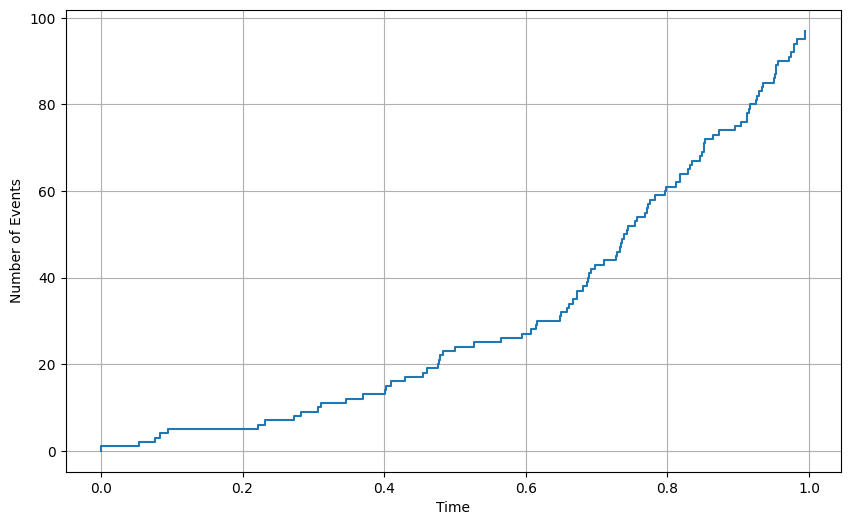

In [13]:
event_counts = np.arange(1, len(events) + 1)
arrival_times = np.insert(events, 0, 0.0)
event_counts = np.insert(event_counts, 0, 0)
plt.figure(figsize=(10, 6))
plt.step(arrival_times, event_counts, where='post')
plt.xlabel("Time")
plt.ylabel("Number of Events")
plt.grid(True)
plt.show()

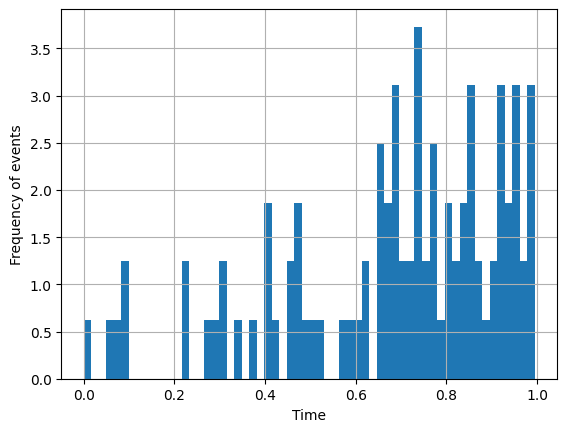

In [14]:
plt.hist(events, bins=60, density=True)
plt.xlabel("Time")
plt.ylabel("Frequency of events")
plt.grid(True)

In [15]:
resutl = {}
resutl['events'] = events
resutl['marks'] = marks
resutl['Sector 1'] = sector_contribs[:,0]
resutl['Sector 2'] = sector_contribs[:,1]
df_Result = pd.DataFrame(resutl)
df_Result

,events,marks,Sector 1,Sector 2
0,0.000108,1.0,0.333333,0.333333
1,0.053651,1.0,0.333333,0.333333
2,0.076873,1.0,0.333333,0.333333
3,0.083601,1.0,0.333333,0.333333
4,0.094878,1.0,0.333333,0.333333
...,...,...,...,...
92,0.978583,1.0,0.333333,0.333333
93,0.979411,1.0,0.333333,0.333333
94,0.982432,1.0,0.333333,0.333333
95,0.994582,1.0,0.333333,0.333333


In [16]:
losses = run_simulation(params, loan_contracts,num_trials=100)

In [17]:
compute_metrics(losses, alpha=0.95)

{'Mean': np.float64(194.44),
 'Std': np.float64(43.51007239708984),
 'VaR': np.float64(271.15),
 'ES': np.float64(288.2),
 'Excess ES': np.float64(17.05000000000001),
 'ExcessKurtosis': np.float64(0.1285478252575234)}

In [18]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


## Experiments - Effect of different schedules on ES (alpha = 0.95) - Balanced sectoral weighting

c = 0.01

J = 3; N = 1000

r = 0.12

N = 12

2500 Monte Carlo Runs

            Mean         Std     VaR           ES   Excess ES  ExcessKurtosis
Bullet  1946.776  454.891642  2750.0  2970.079365  220.079365        0.142128


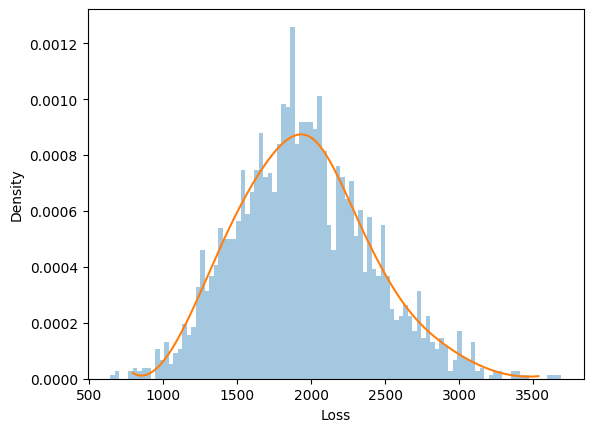

In [19]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR          ES  Excess ES  \
French  569.577516  140.262261  819.043504  888.919786  69.876282   

        ExcessKurtosis  
French        0.163292  


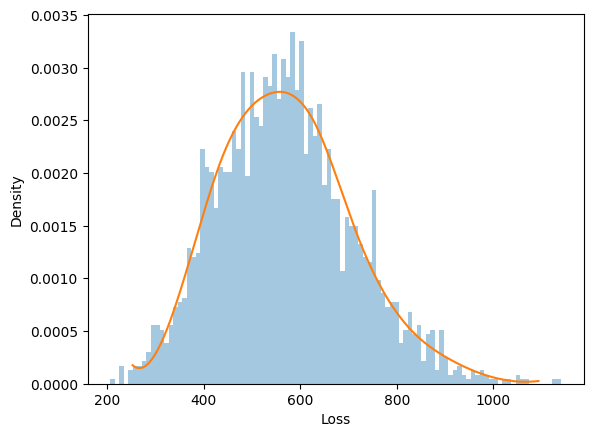

In [20]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean        Std         VaR          ES  Excess ES  \
Linear  556.005667  134.29793  796.666667  859.986772  63.320106   

        ExcessKurtosis  
Linear         0.28042  


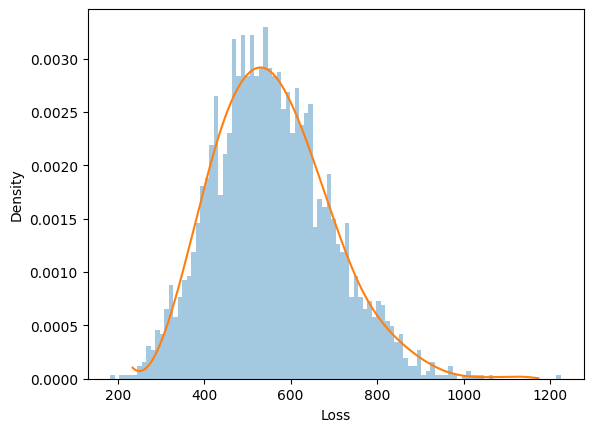

In [21]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [22]:
b_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
b_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,569.577516,140.262261,819.043504,888.919786,69.876282,0.163292
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different schedules on ES (alpha = 0.95) - Concentrated sectoral weighting

c = 0.01

J = 3; N = 1000

r = 0.12

N = 12

2500 Monte Carlo Runs

In [23]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


            Mean         Std     VaR      ES  Excess ES  ExcessKurtosis
Bullet  3793.688  860.322776  5161.0  5505.2      344.2       -0.220644


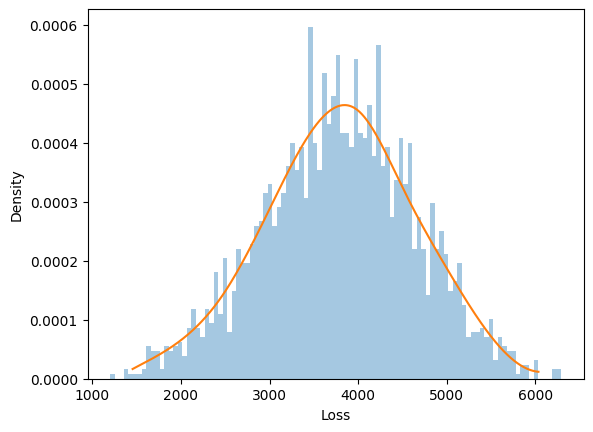

In [24]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

              Mean         Std          VaR           ES  Excess ES  \
French  728.788272  233.022989  1147.238362  1280.214242  132.97588   

        ExcessKurtosis  
French        0.460492  


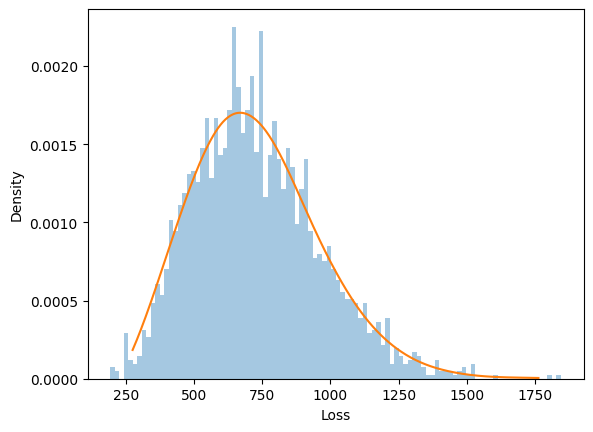

In [25]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean       Std          VaR           ES   Excess ES  \
Linear  706.550667  225.3321  1098.333333  1207.493386  109.160053   

        ExcessKurtosis  
Linear       -0.092527  


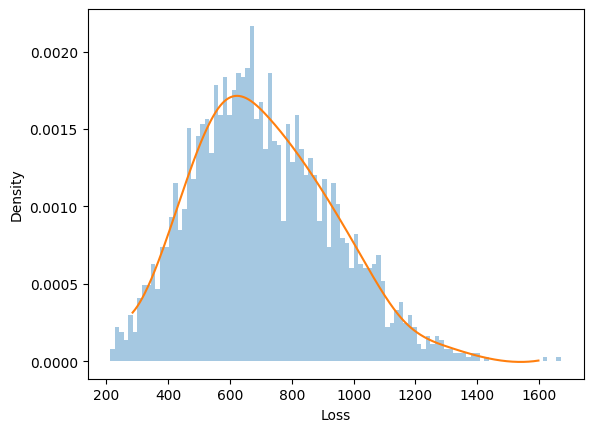

In [26]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [27]:
c_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3793.688000,860.322776,5161.000000,5505.200000,344.200000,-0.220644
French,728.788272,233.022989,1147.238362,1280.214242,132.975880,0.460492
Linear,706.550667,225.332100,1098.333333,1207.493386,109.160053,-0.092527


In [28]:
b_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,569.577516,140.262261,819.043504,888.919786,69.876282,0.163292
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different schedules on ES (alpha = 0.95) - Mixed sectoral weighting

c = 0.01

J = 3; N = 1000

r = 0.12

N = 12

2500 Monte Carlo Runs

In [29]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "mixed", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


            Mean         Std     VaR           ES   Excess ES  ExcessKurtosis
Bullet  2137.508  515.730618  3040.0  3261.190476  221.190476       -0.109966


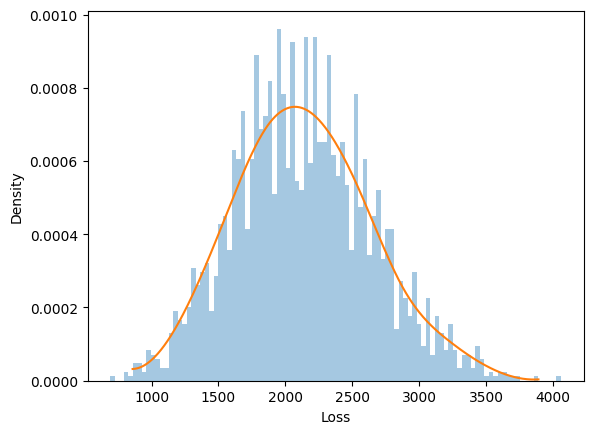

In [30]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR          ES  Excess ES  \
French  564.343923  150.940518  831.519003  920.796043   89.27704   

        ExcessKurtosis  
French        0.320532  


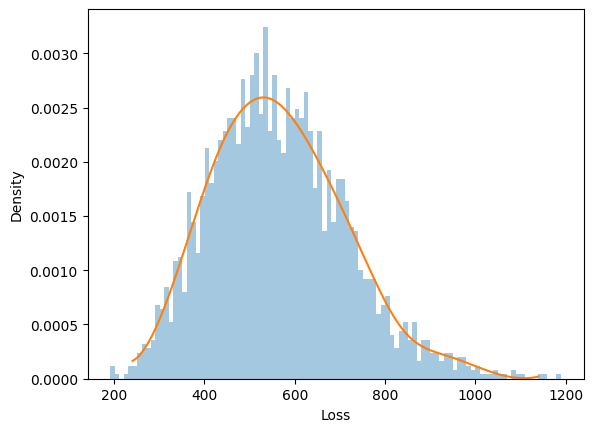

In [31]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean         Std     VaR     ES  Excess ES  ExcessKurtosis
Linear  538.359667  143.441622  789.25  866.6      77.35         0.16287


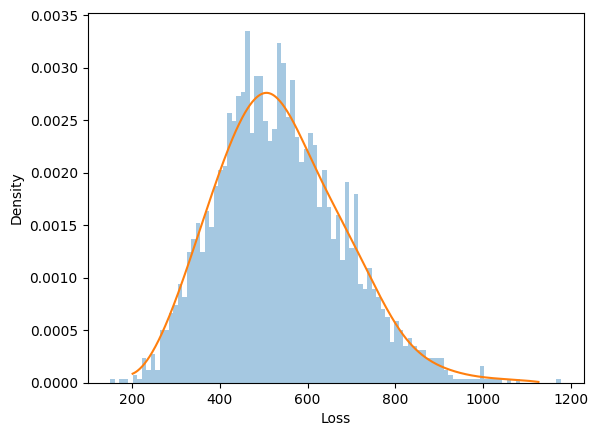

In [32]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [33]:
m_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
m_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,2137.508000,515.730618,3040.000000,3261.190476,221.190476,-0.109966
French,564.343923,150.940518,831.519003,920.796043,89.277040,0.320532
Linear,538.359667,143.441622,789.250000,866.600000,77.350000,0.162870


In [34]:
c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3793.688000,860.322776,5161.000000,5505.200000,344.200000,-0.220644
French,728.788272,233.022989,1147.238362,1280.214242,132.975880,0.460492
Linear,706.550667,225.332100,1098.333333,1207.493386,109.160053,-0.092527


In [35]:
b_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,569.577516,140.262261,819.043504,888.919786,69.876282,0.163292
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different schedules on ES (alpha = 0.95) - Random sectoral weighting

c = 0.01

J = 3; N = 1000

r = 0.12

N = 12

2500 Monte Carlo Runs

In [36]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "random", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


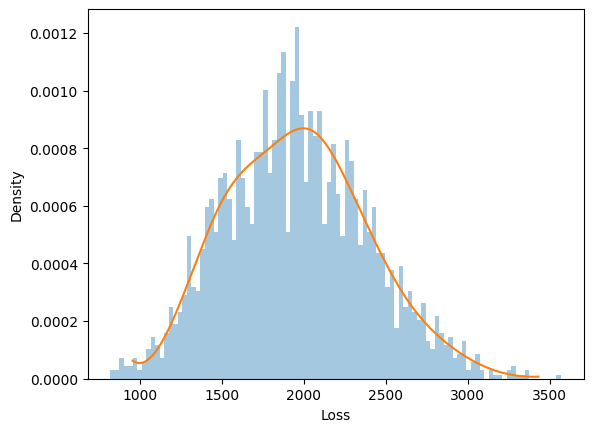

In [37]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])

loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR          ES  Excess ES  \
French  577.525375  140.371555  822.544527  903.372832  80.828305   

        ExcessKurtosis  
French         0.35926  


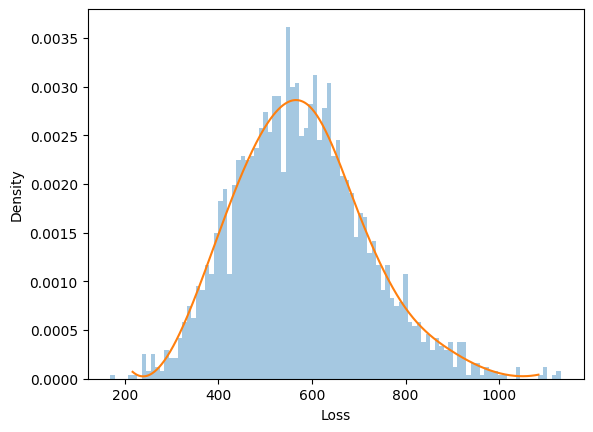

In [38]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean         Std         VaR          ES  Excess ES  \
Linear  559.650333  138.573728  800.041667  879.806667     79.765   

        ExcessKurtosis  
Linear        0.253888  


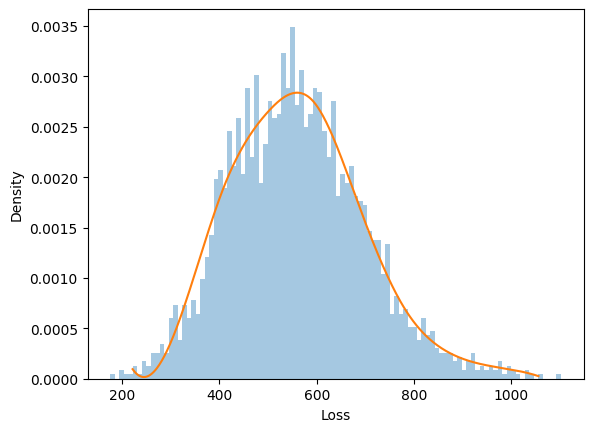

In [39]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [40]:
r_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
r_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1956.800000,440.158608,2720.000000,2908.888889,188.888889,-0.145566
French,577.525375,140.371555,822.544527,903.372832,80.828305,0.359260
Linear,559.650333,138.573728,800.041667,879.806667,79.765000,0.253888


In [41]:
m_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,2137.508000,515.730618,3040.000000,3261.190476,221.190476,-0.109966
French,564.343923,150.940518,831.519003,920.796043,89.277040,0.320532
Linear,538.359667,143.441622,789.250000,866.600000,77.350000,0.162870


In [42]:
c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3793.688000,860.322776,5161.000000,5505.200000,344.200000,-0.220644
French,728.788272,233.022989,1147.238362,1280.214242,132.975880,0.460492
Linear,706.550667,225.332100,1098.333333,1207.493386,109.160053,-0.092527


In [43]:
b_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,569.577516,140.262261,819.043504,888.919786,69.876282,0.163292
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different schedules on ES (alpha = 0.95) - Concentrated sectoral weighting

## Increasing global sensitivity factor c = 0.03

c = 0.03

J = 3; N = 1000

r = 0.12

N = 12

2500 Monte Carlo Runs

In [44]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.03

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "random", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


            Mean         Std     VaR           ES  Excess ES  ExcessKurtosis
Bullet  9514.828  207.470119  9750.0  9781.986301  31.986301        6.758098


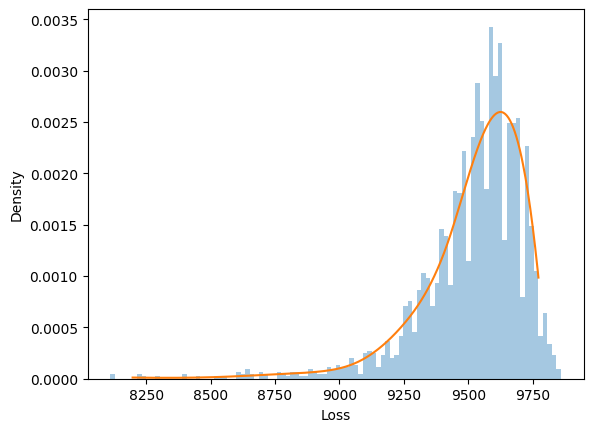

In [45]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

               Mean         Std          VaR           ES   Excess ES  \
French  3037.662249  668.024264  4095.684573  4334.738678  239.054106   

        ExcessKurtosis  
French       -0.233186  


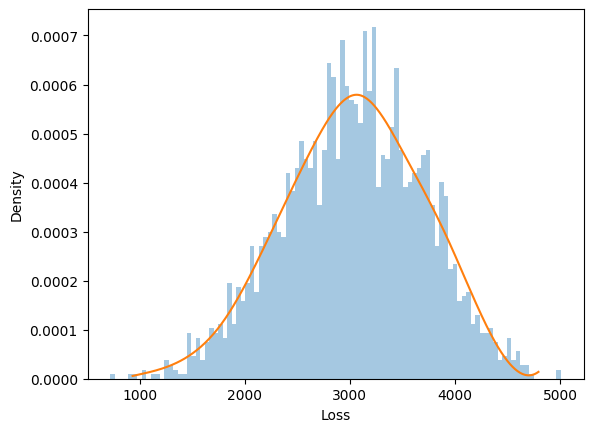

In [46]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

               Mean         Std          VaR           ES  Excess ES  \
Linear  2896.374333  663.571587  3979.333333  4200.973333     221.64   

        ExcessKurtosis  
Linear       -0.141821  


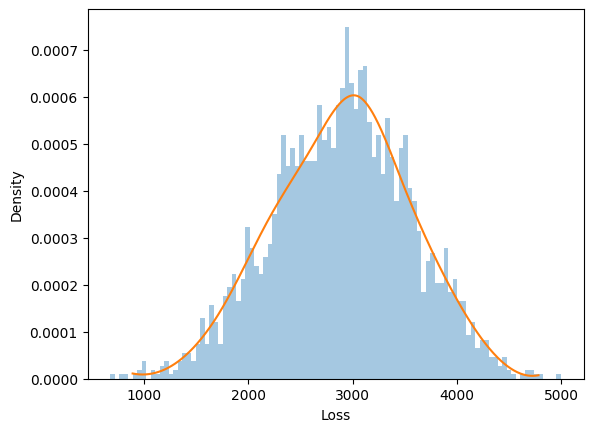

In [47]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [48]:
higher_c_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
higher_c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,9514.828000,207.470119,9750.000000,9781.986301,31.986301,6.758098
French,3037.662249,668.024264,4095.684573,4334.738678,239.054106,-0.233186
Linear,2896.374333,663.571587,3979.333333,4200.973333,221.640000,-0.141821


In [49]:
c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3793.688000,860.322776,5161.000000,5505.200000,344.200000,-0.220644
French,728.788272,233.022989,1147.238362,1280.214242,132.975880,0.460492
Linear,706.550667,225.332100,1098.333333,1207.493386,109.160053,-0.092527


In [50]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.005

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "random", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


          Mean         Std     VaR       ES  Excess ES  ExcessKurtosis
Bullet  916.24  198.109521  1260.5  1375.84     115.34        0.302276


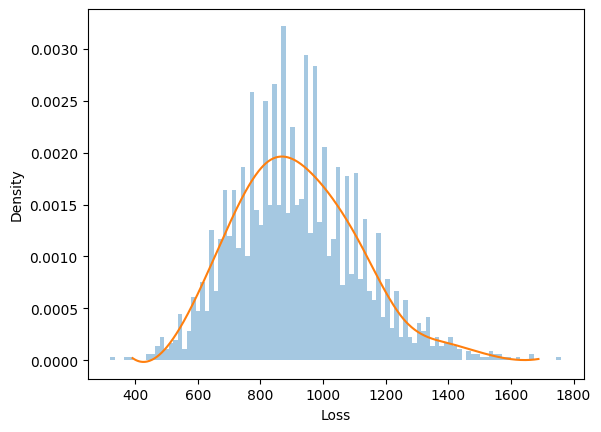

In [51]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

              Mean        Std         VaR          ES  Excess ES  \
French  384.107017  84.319765  533.268968  576.389821  43.120853   

        ExcessKurtosis  
French        0.185836  


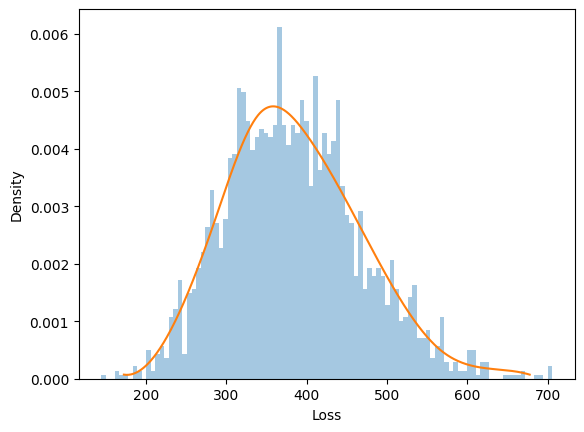

In [52]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean        Std         VaR          ES  Excess ES  \
Linear  375.151333  79.079678  507.541667  556.433333  48.891667   

        ExcessKurtosis  
Linear         0.37096  


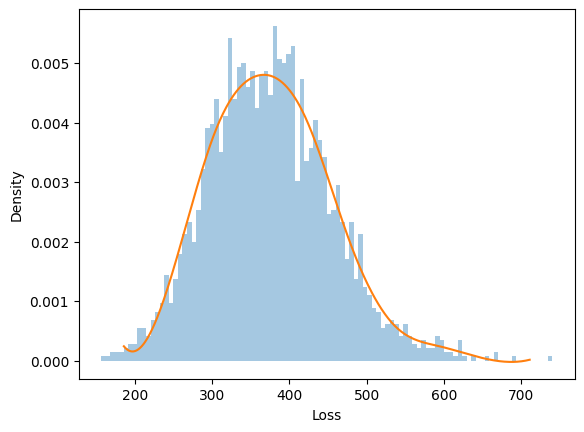

In [53]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [54]:
stable_c_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
stable_c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,916.240000,198.109521,1260.500000,1375.840000,115.340000,0.302276
French,384.107017,84.319765,533.268968,576.389821,43.120853,0.185836
Linear,375.151333,79.079678,507.541667,556.433333,48.891667,0.370960


In [55]:
c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3793.688000,860.322776,5161.000000,5505.200000,344.200000,-0.220644
French,728.788272,233.022989,1147.238362,1280.214242,132.975880,0.460492
Linear,706.550667,225.332100,1098.333333,1207.493386,109.160053,-0.092527


In [56]:
higher_c_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,9514.828000,207.470119,9750.000000,9781.986301,31.986301,6.758098
French,3037.662249,668.024264,4095.684573,4334.738678,239.054106,-0.233186
Linear,2896.374333,663.571587,3979.333333,4200.973333,221.640000,-0.141821


## Experiments - Effect of different interest rates on ES (alpha = 0.95) - Balanced sectoral weighting

## Increasing r to 0.15

c = 0.01

J = 3; N = 1000

r = 0.15

N = 12

2500 Monte Carlo Runs

In [57]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.01

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


            Mean         Std     VaR           ES   Excess ES  ExcessKurtosis
Bullet  1946.776  454.891642  2750.0  2970.079365  220.079365        0.142128


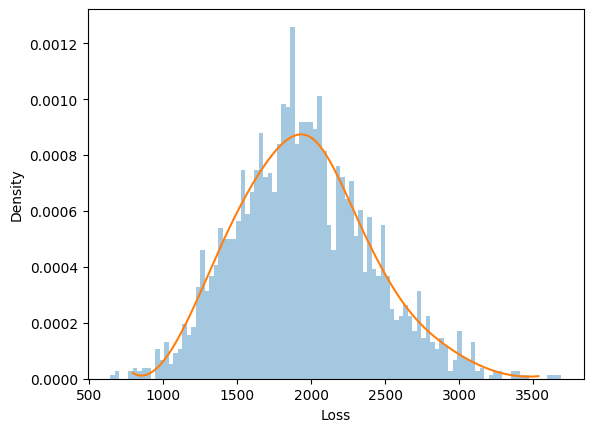

In [58]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.15,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR          ES  Excess ES  \
French  575.386765  142.688162  828.477164  910.259888  81.782724   

        ExcessKurtosis  
French        0.595347  


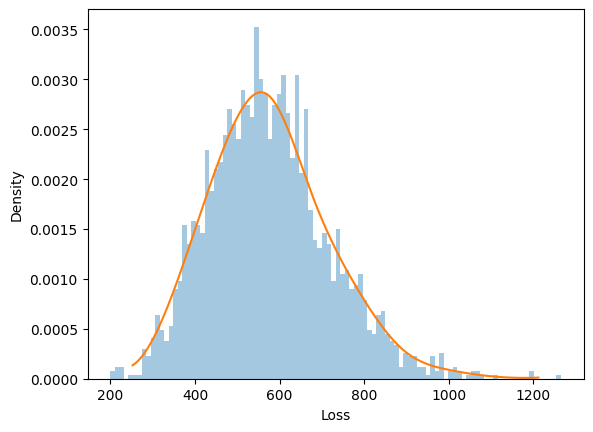

In [59]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.15,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean        Std         VaR          ES  Excess ES  \
Linear  556.005667  134.29793  796.666667  859.986772  63.320106   

        ExcessKurtosis  
Linear         0.28042  


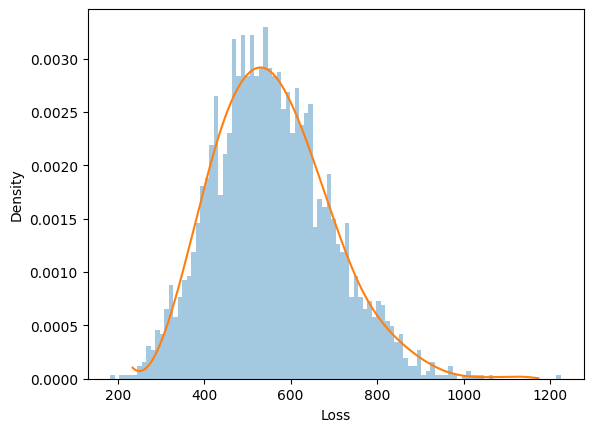

In [60]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.15,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [61]:
higher_r_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
higher_r_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,575.386765,142.688162,828.477164,910.259888,81.782724,0.595347
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different interest rates on ES (alpha = 0.95) - Balanced sectoral weighting

## Decreasing r to 0.10

c = 0.01

J = 3; N = 1000

r = 0.10

N = 12

2500 Monte Carlo Runs

            Mean         Std     VaR           ES   Excess ES  ExcessKurtosis
Bullet  1946.776  454.891642  2750.0  2970.079365  220.079365        0.142128


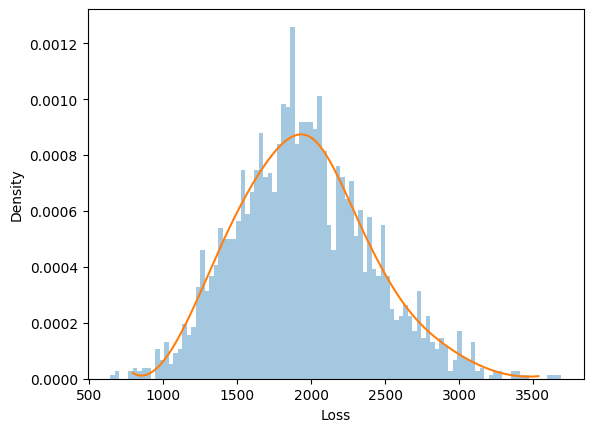

In [62]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.10,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)
loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR         ES  Excess ES  \
French  567.048178  138.981918  814.162588  887.68195  73.519362   

        ExcessKurtosis  
French        0.141588  


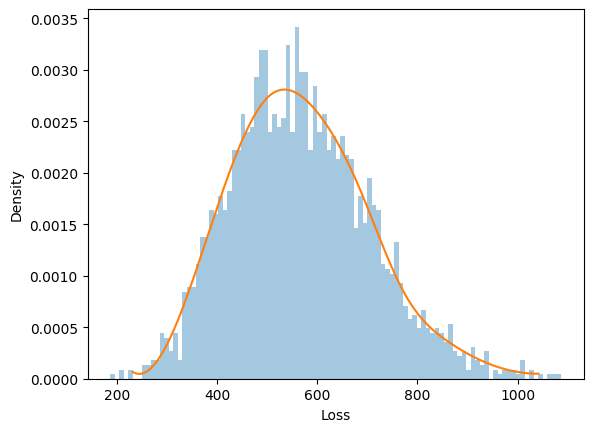

In [63]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.10,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean        Std         VaR          ES  Excess ES  \
Linear  556.005667  134.29793  796.666667  859.986772  63.320106   

        ExcessKurtosis  
Linear         0.28042  


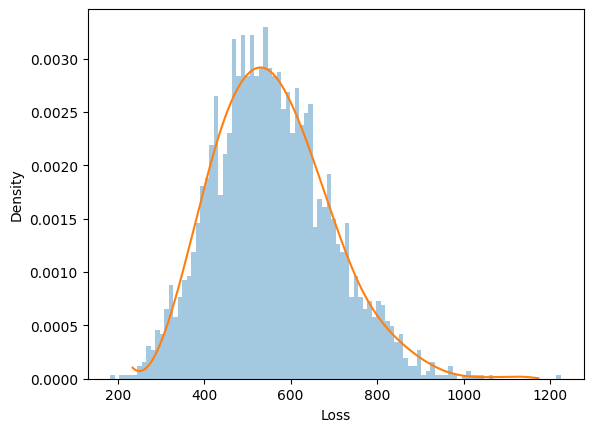

In [64]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.10,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')


In [65]:
lower_r_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
lower_r_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,567.048178,138.981918,814.162588,887.681950,73.519362,0.141588
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experiments - Effect of different interest rates on ES (alpha = 0.95) - Balanced sectoral weighting

## Decreasing r to 0.07

c = 0.01

J = 3; N = 1000

r = 0.07

N = 12

2500 Monte Carlo Runs

            Mean         Std     VaR           ES   Excess ES  ExcessKurtosis
Bullet  1946.776  454.891642  2750.0  2970.079365  220.079365        0.142128


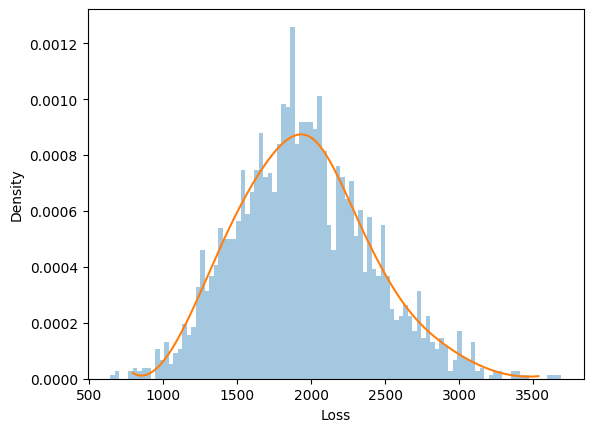

In [66]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.07,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=2500)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)
loss_distribution_plot(losses_b, 'bullet')

              Mean         Std         VaR          ES  Excess ES  \
French  566.335571  137.744354  803.230546  879.756112  76.525566   

        ExcessKurtosis  
French         0.14467  


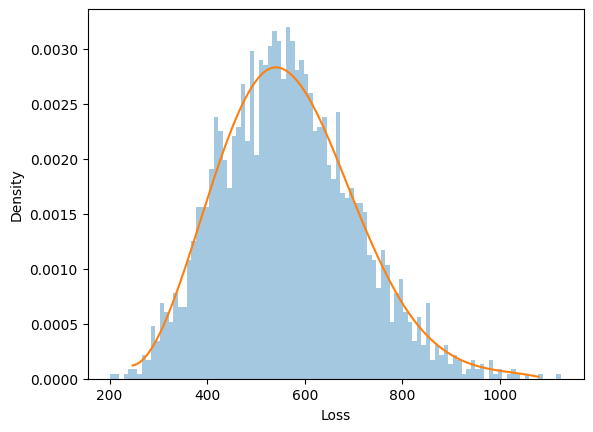

In [67]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.07,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=2500)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'french')

              Mean        Std         VaR          ES  Excess ES  \
Linear  556.005667  134.29793  796.666667  859.986772  63.320106   

        ExcessKurtosis  
Linear         0.28042  


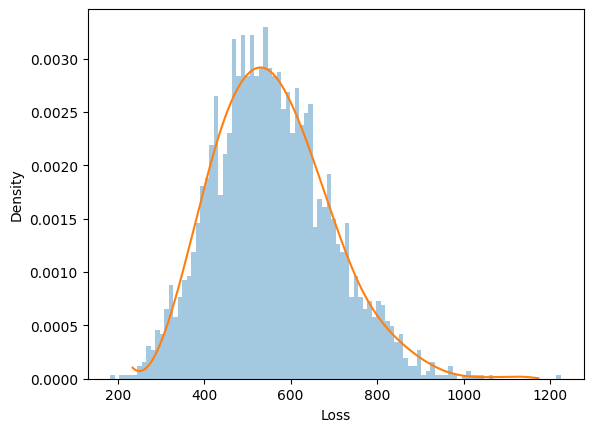

In [68]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.07,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=2500)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'linear')

In [69]:
lower_r2_metrics_combined_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
lower_r2_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,566.335571,137.744354,803.230546,879.756112,76.525566,0.144670
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experimenting with negative amortisation schedules - Balanced Sectoral Regime

c = 0.03

r = 0.07

N = 12

J = 3, N_firms = 1000

2500 Monte Csarlo runs

In [70]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.03

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


                               Mean         Std           VaR            ES  \
Negative Amortization  10261.519593  116.984349  10397.401949  10420.754973   

                       Excess ES  ExcessKurtosis  
Negative Amortization  23.353024       21.248684  


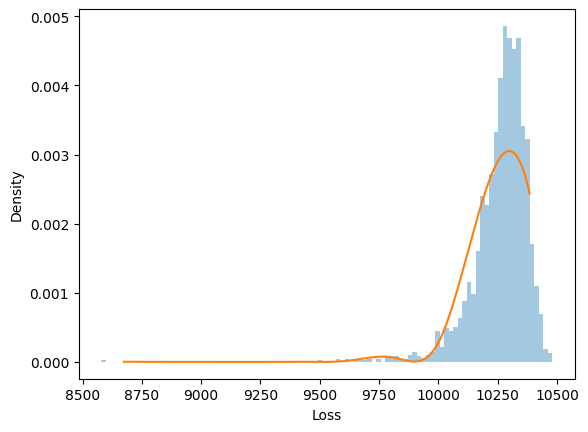

In [71]:
loan_neg = [
    {
        "type": 'negative_amortisation',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_neg = run_simulation(params, loan_neg, num_trials=2500)
metrics_neg = compute_metrics(losses_neg, alpha=0.95)
metrics_neg_df = pd.DataFrame(metrics_neg, index=['Negative Amortization'])
print(metrics_neg_df)

loss_distribution_plot(losses_neg, 'negative_amortization')

In [72]:
metrics_neg_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Negative Amortization,10261.519593,116.984349,10397.401949,10420.754973,23.353024,21.248684


In [73]:
lower_r2_metrics_combined_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,1946.776000,454.891642,2750.000000,2970.079365,220.079365,0.142128
French,566.335571,137.744354,803.230546,879.756112,76.525566,0.144670
Linear,556.005667,134.297930,796.666667,859.986772,63.320106,0.280420


## Experimenting with negative amortisation schedules - Concentrated Sectoral Regime

c = 0.03

r = 0.07

N = 12

J = 3, N_firms = 1000

2500 Monte Csarlo runs

In [74]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.03

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


                               Mean        Std           VaR            ES  \
Negative Amortization  10444.064049  54.995178  10546.422071  10575.876857   

                       Excess ES  ExcessKurtosis  
Negative Amortization  29.454786        0.270981  


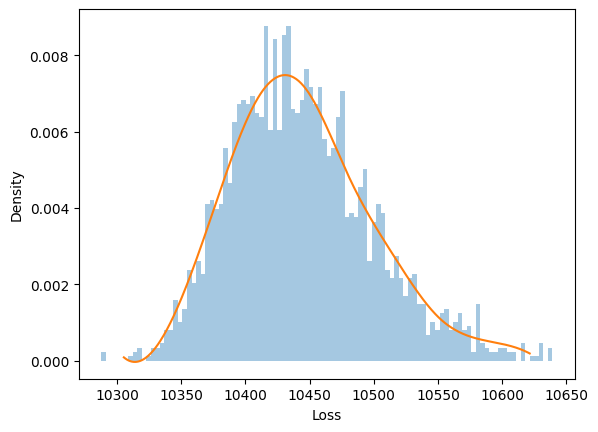

In [75]:
loan_neg = [
    {
        "type": 'negative_amortisation',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_neg = run_simulation(params, loan_neg, num_trials=2500)
metrics_neg = compute_metrics(losses_neg, alpha=0.95)
metrics_neg_df_1 = pd.DataFrame(metrics_neg, index=['Negative Amortization'])
print(metrics_neg_df_1)

loss_distribution_plot(losses_neg, 'negative_amortization')

In [76]:
metrics_neg_df_1

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Negative Amortization,10444.064049,54.995178,10546.422071,10575.876857,29.454786,0.270981


In [77]:
metrics_neg_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Negative Amortization,10261.519593,116.984349,10397.401949,10420.754973,23.353024,21.248684


## Mixed loan contracts - Balanced sectoral regime

ceterus paribus

r = 0.12

c = 0.03

N = 12

N_firms = 1000; J = 3



In [78]:
mixed_loan_contracts = [
    {
        "type": ['bullet','bullet','french', 'french', 'french', 'french', 'french'][i%7],
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

In [79]:
rng = np.random.default_rng(21)

N_firms = 1000
J = 3

c = 0.03

T = 1

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [  1.94909482 142.38657494   3.29635058]


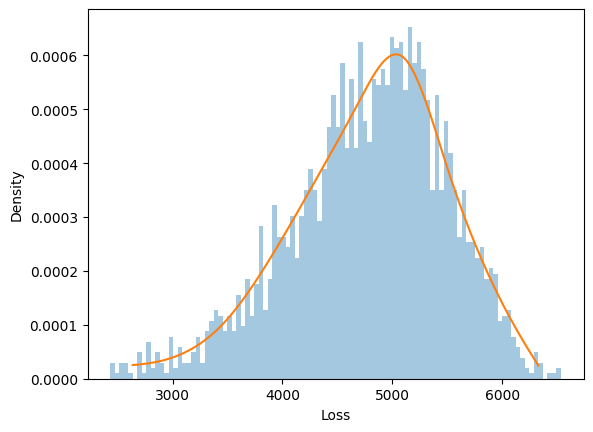

In [80]:
losses_mix = run_simulation(params, mixed_loan_contracts, num_trials=2500)
metrics_mix = compute_metrics(losses_mix, alpha=0.95)
metrics_mix_df = pd.DataFrame(metrics_mix, index=['Mixed'])
metrics_mix_df

loss_distribution_plot(losses_mix, 'mixed')

In [81]:
metrics_mix_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Mixed,4788.131811,708.54605,5844.466142,6024.377402,179.91126,0.128871
